In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from mlxtend.data import loadlocal_mnist

In [2]:
class NeuralNetwork:
    
    def __init__(self, hidden_dims, loss_fn, input_dim = 28*28, output_size = 1, weight_scale = None, dtype=np.float32):
        self.params = {}
        self.num_layers = len(hidden_dims) + 1
        
        self.loss_fn = loss_fn
        
        for i in range(self.num_layers):
            if(i == 0):
                if weight_scale is None:
                    self.params['W1'] = np.random.randn(input_dim, hidden_dims[0]) * np.sqrt(2/input_dim)
                else:
                    self.params['W1'] = np.random.randn(input_dim, hidden_dims[0]) * weight_scale
                self.params['b1'] = np.zeros(hidden_dims[0], dtype=dtype)
            elif(i == self.num_layers-1):
                if weight_scale is None:
                    self.params['W'+str(i+1)] = np.random.randn(hidden_dims[i-1], output_size) * np.sqrt(2/input_dim)
                else:
                    self.params['W'+str(i+1)] = np.random.randn(hidden_dims[i-1], output_size) * weight_scale 
                self.params['b'+str(i+1)] = np.zeros(output_size, dtype=dtype)
            else:
                if weight_scale is None:
                    self.params['W'+str(i+1)] = np.random.randn(hidden_dims[i-1], hidden_dims[i]) * np.sqrt(2/input_dim)
                else:
                    self.params['W'+str(i+1)] = np.random.randn(hidden_dims[i-1], hidden_dims[i]) * weight_scale
                self.params['b'+str(i+1)] = np.zeros(hidden_dims[i], dtype=dtype)
    
    def loss(self, X, Y=None):
        
        scores = None
        
        out = X
        cache = {}
        
        for i in range(self.num_layers-1):
            #out, cache['dense_relu'+str(i+1)] = dense_relu_forward(out, self.params['W'+str(i+1)], 
                                                        #self.params['b'+str(i+1)])
            out, cache['dense_sigmoid'+str(i+1)] = dense_sigmoid_forward(out, self.params['W'+str(i+1)], 
                                                        self.params['b'+str(i+1)])
        
        scores, cache['dense'] = dense_forward(out, self.params['W'+str(self.num_layers)], self.params['b'+str(self.num_layers)])
        
        if Y is None:
            return scores
        
        loss, dout = self.loss_fn(scores, Y)
        
        grads = {}
        
        dout, grads['W'+str(self.num_layers)], grads['b'+str(self.num_layers)] = dense_backward(dout, cache['dense'])
        
        for i in range(self.num_layers-1, 0, -1):
            #dout, dW, db = dense_relu_backward(dout, cache['dense_relu'+str(i)])
            
            dout, dW, db = dense_sigmoid_backward(dout, cache['dense_sigmoid'+str(i)])
            
            grads['W'+str(i)], grads['b'+str(i)] = dW, db
        
        return loss, grads
    
    def predict(self, X):
        predictions, _ = sigmoid_forward(self.loss(X))
        predictions[predictions>0.5] = 1
        predictions[predictions<=0.5] = 0
        
        return predictions

In [3]:
def dense_forward(x, W, b):
    out = x @ W + b
    
    cache = (x, W, b)
    
    return out, cache

def dense_backward(dout, cache):
    x, W, b = cache
    
    N = x.shape[0]
    
    dW = x.T @ dout
    dx = dout @ W.T
    db = np.sum(dout, axis=0)
    
    return dx, dW, db

# x if x>0 else 0
def relu_forward(x):
    pass

# Note: function is not derivable at x=0, for the implementation pupuse lets assume f'(0) = 0
def relu_backward(dout, cache):
    pass

def sigmoid_forward(x):
    out = 1 / (1 + np.exp(-x))
    cache = out
    return out, cache

def sigmoid_backward(dout, cache):
    z = cache
    dz = z*(1-z)
    return dout*dz

In [4]:
def dense_sigmoid_forward(x, W, b):
    out, cache_dense = dense_forward(x, W, b)
    out, cache_sigmoid = sigmoid_forward(out)
    cache = (cache_dense, cache_sigmoid)
    return out, cache

def dense_sigmoid_backward(dout, cache):
    cache_dense, cache_sigmoid = cache
    
    dout = sigmoid_backward(dout, cache_sigmoid)
    dout, dW, db = dense_backward(dout, cache_dense)
    
    return dout, dW, db

def dense_relu_forward(x, W, b):
    out, cache_dense = dense_forward(x, W, b)
    out, cache_relu = relu_forward(out)
    cache = (cache_dense, cache_relu)
    return out, cache

def dense_relu_backward(dout, cache):
    cache_dense, cache_relu = cache
    
    dout = relu_backward(dout, cache_relu)
    dout, dW, db = dense_backward(dout, cache_dense)
    
    return dout, dW, db

In [5]:
def loss_fn(scores, y, eps=1e-6):
    y_pred, _ = sigmoid_forward(scores)
    
    y_t = y.reshape(y.shape[0], 1)
    
    l = y_t * np.log(y_pred + eps) + (1 - y_t) * np.log(1 - y_pred + eps)
    l = l.mean()
    l *= -1
    
    dl = (y_pred - y_t) / y.shape[0]
    
    return l, dl

## Load Data

In [6]:
#!pip3 install --user mlxtend sklearn numpy matplotlib
#!curl -O http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
#!curl -O http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
#!gunzip t*-ubyte.gz

In [7]:
X, y = loadlocal_mnist(
        images_path='./train-images-idx3-ubyte', 
        labels_path='./train-labels-idx1-ubyte')

In [8]:
X, y = np.concatenate([X[y == 3], X[y==1]]), np.concatenate([np.full(y[y == 3].shape, 0), np.full(y[y == 1].shape, 1)])
X_train, X_val_test, y_train, y_val_test = train_test_split(X.astype(np.float), y, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, train_size=0.66)

X_train /= 255.0
X_val /= 255.0
X_test /= 255.0

In [9]:
X_train.shape

(9011, 784)

## Copy-paste from past :) 

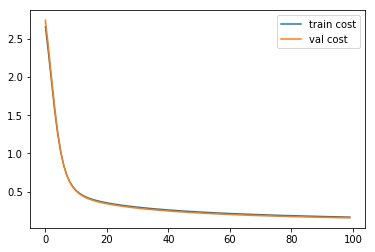

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def evaluate(W, X):
    result = X @ W
    return sigmoid(result)

def loss(W, X, Y, eps):
    y_pred = evaluate(W, X)
    result = Y * np.log(y_pred + eps) + (1 - Y) * np.log(1 - y_pred + eps)
    result = result.mean()
    result *= -1
    return result

def gradient_step(W, X, Y, lr):
    Y_hat = evaluate(W, X)
    errors = Y_hat - Y
    dW = (X.T @ errors) / len(errors)
    return W - dW * lr

def add_bias_feature(X):
       return np.c_[np.ones(len(X)), X]
    
learning_rate = 0.1
eps = 0.001
train_steps = 100

W = np.random.randn(X_train.shape[1])

train_costs = []
val_costs = []

for _ in range(train_steps):
    train_costs.append(loss(W, X_train, y_train, eps=eps))
    val_costs.append(loss(W, X_val, y_val, eps=eps))
    W = gradient_step(W, X_train, y_train, lr=learning_rate)
    
plt.close()

plt.plot(np.arange(train_steps), train_costs)
plt.plot(np.arange(train_steps), val_costs)
plt.legend(["train cost", "val cost"])
plt.show()

In [11]:
positive_ind = np.argwhere(y_val == 1).reshape(-1)
negative_ind = np.argwhere(y_val == 0).reshape(-1)
X_val_pos = X_val[positive_ind]
y_val_pos = y_val[positive_ind]
X_val_neg = X_val[negative_ind]
y_val_neg = y_val[negative_ind]

In [12]:
y_test_pred = evaluate(W, X_test)
y_test_pred[y_test_pred > 0.5] = 1
y_test_pred[y_test_pred <= 0.5] = 0

accuracy_score(y_test, y_test_pred)

0.9505327245053272

## Use 1 hidden layer neural network

iteration 0, loss: 0.628131
iteration 1, loss: 0.591317
iteration 2, loss: 0.558010
iteration 3, loss: 0.527830
iteration 4, loss: 0.500105
iteration 5, loss: 0.474539
iteration 6, loss: 0.450818
iteration 7, loss: 0.428724
iteration 8, loss: 0.408082
iteration 9, loss: 0.388757
iteration 10, loss: 0.370646
iteration 11, loss: 0.353668
iteration 12, loss: 0.337757
iteration 13, loss: 0.322853
iteration 14, loss: 0.308898
iteration 15, loss: 0.295837
iteration 16, loss: 0.283618
iteration 17, loss: 0.272189
iteration 18, loss: 0.261497
iteration 19, loss: 0.251495
iteration 20, loss: 0.242135
iteration 21, loss: 0.233374
iteration 22, loss: 0.225168
iteration 23, loss: 0.217479
iteration 24, loss: 0.210269
iteration 25, loss: 0.203504
iteration 26, loss: 0.197150
iteration 27, loss: 0.191179
iteration 28, loss: 0.185562
iteration 29, loss: 0.180273
iteration 30, loss: 0.175289
iteration 31, loss: 0.170588
iteration 32, loss: 0.166150
iteration 33, loss: 0.161956
iteration 34, loss: 0.15

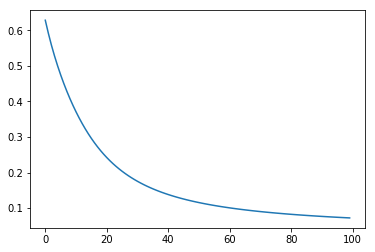

In [26]:
model = NeuralNetwork([128], loss_fn, weight_scale = np.float(0.1))

num_steps = 100

loss_history = []
lr = 0.2

#X_tr = X_train
#y_tr = y_train

#print(y_tr)

X_train = X_train
y_train = y_train

for i in range(num_steps):    
    #h = model.loss(batch_x)
    #print(h)
    
    loss, grads = model.loss(X_train, y_train)
    
    print('iteration %d, loss: %f'%(i, loss))
    
    loss_history.append(loss)
    
    for param_name, param_val in model.params.items():
        model.params[param_name] = param_val - lr*grads[param_name]

plt.plot(loss_history)
plt.show()

In [23]:
y_test_pred = model.predict(X_test)

In [24]:
accuracy_score(y_test, y_test_pred)

0.982496194824962